In [1]:
import numpy as np
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pickle

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

from architectures.bicycle_GAN import *
from architectures.utils.toolbox import *

In [2]:
task='TEST'

PATH='test12'

In [3]:
if task == 'TEST' and os.path.exists(PATH+'/hyper_parameters.pkl'):
    with open(PATH+'/hyper_parameters.pkl', 'rb') as f:  
        hyper_dict = pickle.load(f)
        for key, item in hyper_dict.items():
            print(key+':'+str(item))
     
    reco_path = hyper_dict['reco_path']
    true_path = hyper_dict['true_path']
    #true_path_p = hyper_dict['true_path_p']
    #true_path_K = hyper_dict['true_path_K']
    n_batches = hyper_dict['n_batches']
    test_size = hyper_dict['test_size']
    LEARNING_RATE = hyper_dict['LEARNING_RATE']
    BETA1 = hyper_dict['BETA1']
    BATCH_SIZE = hyper_dict['BATCH_SIZE']
    EPOCHS = hyper_dict['EPOCHS']
    SAVE_SAMPLE_PERIOD = hyper_dict['SAVE_SAMPLE_PERIOD']
    SEED = hyper_dict['SEED']
    d_sizes = hyper_dict['d_sizes']
    g_sizes_enc = hyper_dict['g_sizes_enc']
    g_sizes_dec = hyper_dict['g_sizes_dec']
    e_sizes = hyper_dict['e_sizes']
    cost_type = hyper_dict['cost_type']
    validating_size=hyper_dict['validating_size']
    cycl_weight=hyper_dict['cycl_weight']
    latent_weight=hyper_dict['latent_weight']
    kl_weight=hyper_dict['kl_weight']
    discr_steps=hyper_dict['discr_steps']
    gen_steps=hyper_dict['gen_steps']
    vae_steps=hyper_dict['vae_steps']
    

if task == 'TEST' and not os.path.exists(PATH+'/hyper_parameters.pkl'):
    
    print('Missing hyperparameter dictionary in save folder')
    
    
    

LEARNING_RATE:0.0004
BETA1:0.5
BATCH_SIZE:16
EPOCHS:3
SAVE_SAMPLE_PERIOD:400
SEED:1
d_sizes:{'conv_layers': [(8.0, 4, 2, False, 1, <function lrelu at 0x7fcab0a15ea0>, <tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcaaacad9b0>), (16, 4, 2, 'bn', 0.8, <function lrelu at 0x7fcab0a15ea0>, <tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcaaacadb70>), (32, 4, 2, 'bn', 1, <function lrelu at 0x7fcab0a15ea0>, <tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcaaacadba8>), (64, 4, 2, 'bn', 0.8, <function lrelu at 0x7fcab0a15ea0>, <tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcaaacadbe0>), (128, 4, 1, 'bn', 1, <function lrelu at 0x7fcab0a15ea0>, <tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcaaacadc18>)], 'dense_layers': [(512, 'bn', 0.8, <function lrelu at 0x7fcab0a15ea0>, <tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcaaacadc50>), (64, 'bn', 0.8, <function lrelu at 0x7fcab0a15ea0>, <tensorflow.python.ops.in

In [4]:
test_size=3000
n_batches=2
start_batch=2

train_true, test_true, train_TIS_true, test_TIS_true, train_TOS_true, test_TOS_true, train_reco, test_reco = load_data(true_path, reco_path, n_batches, start_batch,  test_size=test_size)
    
train_true, train_reco = delete_undetected_events_double(train_true, train_reco)
test_true, test_reco = delete_undetected_events_double(test_true, test_reco)

In [5]:
test_true.shape

(3000, 52, 64, 1)

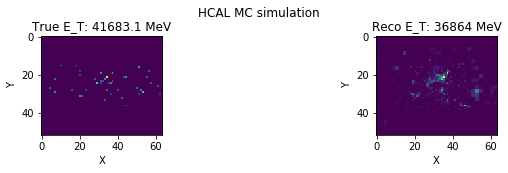

In [6]:
#if preprocess != False:
draw_one_sample(train_true, train_reco,
                    min_true=min_true, max_true=max_true, 
                    min_reco=min_reco, max_reco=max_reco,
                    save=False, PATH=PATH
                   )
#else:
#    draw_one_sample(train_true,train_reco)

In [7]:
train_true.shape, test_true.shape

((37000, 52, 64, 1), (3000, 52, 64, 1))

In [8]:
h=test_reco[0].shape[0]
w=test_reco[0].shape[1]

In [9]:
def HCAL():

    
    tf.reset_default_graph()
    
    _, n_H_A, n_W_A ,n_C = train_true.shape
    _, n_H_B, n_W_B ,n_C = train_reco.shape
    
    gan = bicycle_GAN(n_H_A, n_W_A, n_H_B, n_W_B, n_C,
                   min_true=min_true, max_true=max_true, 
                   min_reco=min_reco, max_reco=max_reco,
                   d_sizes=d_sizes, g_sizes_enc=g_sizes_enc, g_sizes_dec=g_sizes_dec, e_sizes=e_sizes,
                   lr=LEARNING_RATE, beta1=BETA1,
                   cost_type=cost_type, cycl_weight=cycl_weight, latent_weight=latent_weight, kl_weight=kl_weight,
                   discr_steps=discr_steps, gen_steps=gen_steps, vae_steps=vae_steps,
                   batch_size=BATCH_SIZE, epochs=EPOCHS,
                   save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed= SEED)
    
    vars_D = [v for v in tf.trainable_variables() if 'discriminator' in v.name]
    vars_G = [v for v in tf.trainable_variables() if 'generator' in v.name]
    vars_E = [v for v in tf.trainable_variables() if 'encoder' in v.name]
    
    if task == 'TEST':
        
        vars_to_train=tf.trainable_variables()
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
        
        saver=tf.train.Saver()
        
    # Add ops to save and restore all the variables.
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.15)
    
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(init_op)
                       
        if task=='TEST':
            
            print('\n Evaluate model on test set...')
            
            #if os.path.exists(PATH+'/pretrained/'+PATH+'.ckpt.index'):
            #    saver.restore(sess,PATH+'/'+PATH+'pretrained.ckpt')
                
            if os.path.exists(PATH+'/'+PATH+'bicycle.ckpt.index'):
                saver.restore(sess, PATH+'/'+PATH+'bicycle.ckpt')
                
            print('Model restored.')
            
            gan.set_session(sess)
        
        #test_reco_NN=gan.get_samples_A_to_B(test_true.reshape(test_true.shape[0],n_H_A,n_W_A,n_C))
        test_reco_NN=np.zeros_like(test_true)
        for i in range(len(test_true)):
            test_reco_NN[i]=gan.get_sample_A_to_B(test_true[i].reshape(1,n_H_A,n_W_A,n_C))

        done = True
        while not done:
            

            if preprocess:
                draw_nn_sample(test_true, test_reco, 1, preprocess,
                              min_true=min_true, max_true=max_true, 
                              min_reco=min_reco, max_reco=max_reco,
                              f=gan.get_sample_A_to_B, save=False, is_training=False, PATH=PATH)
            else:
                draw_nn_sample(test_true, test_reco, 1, preprocess,
                              f=gan.get_sample_A_to_B, save=False, is_training=False)
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True
        
        done = True
        while not done:
            
            if preprocess:
                draw_nn_sample(test_true, test_reco, 20, preprocess,
                              min_true=min_true, max_true=max_true, 
                              min_reco=min_reco, max_reco=max_reco,
                              f=gan.get_sample_A_to_B, save=False, is_training=False)
            else:
                draw_nn_sample(test_true, test_reco, 20, preprocess,
                              f=gan.get_sample_A_to_B, save=False, is_training=False)
                
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True
        
        return test_reco_NN

In [10]:
if __name__=='__main__':

    if task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            test_reco_NN =HCAL()

Convolutional Network architecture detected for discriminator B
Convolutional Network architecture detected for encoder B
Encoder_B
Convolution
Input for convolution shape  (?, 52, 64, 1)
Encoder output shape (?, 128)
Generator_A_to_B
Input for generator encoded shape (?, 52, 64, 1)
Output of generator encoder, 
 and input for generator decoder shape (?, 1, 1, 1024)
Generator output shape (?, 52, 64, 1)
Generator_A_to_B
Input for generator encoded shape (?, 52, 64, 1)
Output of generator encoder, 
 and input for generator decoder shape (?, 1, 1, 1024)
Generator output shape (?, 52, 64, 1)
Encoder_B
Convolution
Input for convolution shape  (?, 52, 64, 1)
Encoder output shape (?, 128)
Discriminator_B
Input for convolution shape  (?, 52, 64, 1)
minibatch features shape (?, 10)
Feature output shape (?, 64)
Logits shape (?, 1)
Discriminator_B
Input for convolution shape  (?, 52, 64, 1)
minibatch features shape (?, 10)
Feature output shape (?, 64)
Logits shape (?, 1)
Discriminator_B
Input fo

In [11]:
scale=test_reco_NN.std()/test_reco.std()

In [12]:
scale

0.6232238

In [21]:
test_reco_MC_hist= test_reco.reshape(test_reco.shape[0],test_reco.shape[1]*test_reco.shape[2])
test_reco_MC_hist = np.sum(test_reco_MC_hist,axis=1)
max_MC_hist = np.max(test_reco_MC_hist)

test_reco_NN_test=test_reco_NN/0.9
test_reco_NN_hist= test_reco_NN_test.reshape(test_reco_NN_test.shape[0],test_reco_NN.shape[1]*test_reco_NN.shape[2])
test_reco_NN_hist = np.sum(test_reco_NN_hist,axis=1)
max_NN_hist = np.max(test_reco_NN_hist)

test_true_hist= test_true.reshape(test_true.shape[0],test_true.shape[1]*test_true.shape[2])
test_true_hist = np.sum(test_true_hist,axis=1)
max_true_hist = np.max(test_true_hist)

#test_reco_NN_hist_rescaled=(test_reco_NN_hist/max_NN_hist)*max_MC_hist


In [22]:
diffNN = test_reco_NN_hist-test_true_hist
diffMC = test_reco_MC_hist-test_true_hist

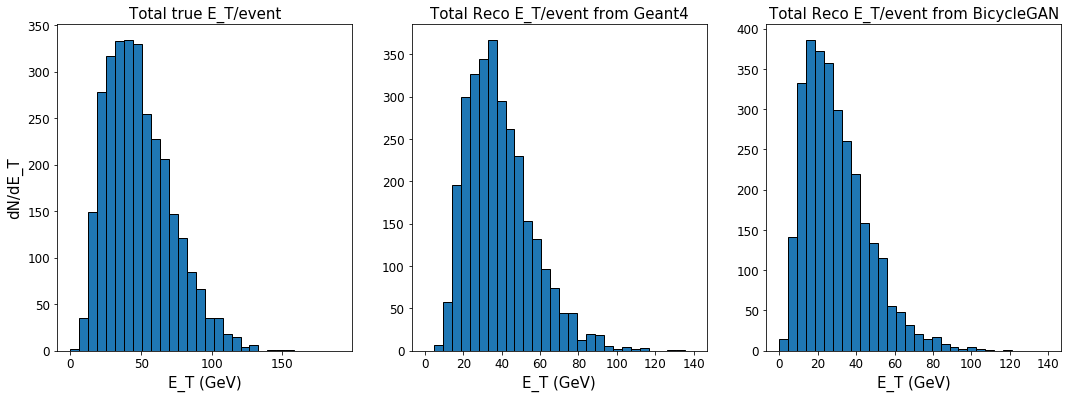

In [23]:
plt.subplot(1,3,1)
plt.tick_params(labelsize=12);
h_reco = plt.hist(test_true_hist/1000,bins=30,range=(0,190), edgecolor='black');
plt.xlabel('E_T (GeV)', fontsize=15)
plt.ylabel('dN/dE_T', fontsize=15)
plt.title('Total true E_T/event', fontsize=15)
plt.subplot(1,3,2)
plt.tick_params(labelsize=12);
h_reco = plt.hist(test_reco_MC_hist/1000,bins=30,range=(0,140), edgecolor='black');
plt.xlabel('E_T (GeV)', fontsize=15)

plt.title('Total Reco E_T/event from Geant4', fontsize=15)
plt.subplot(1,3,3)
plt.tick_params(labelsize=12);
h_nn = plt.hist(test_reco_NN_hist/1000, bins=30,range=(0,140),  edgecolor='black');
plt.xlabel('E_T (GeV)', fontsize=15)

plt.title('Total Reco E_T/event from BicycleGAN', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(18,6)
plt.savefig(PATH+'/distribution.eps', format='eps', dpi=100)

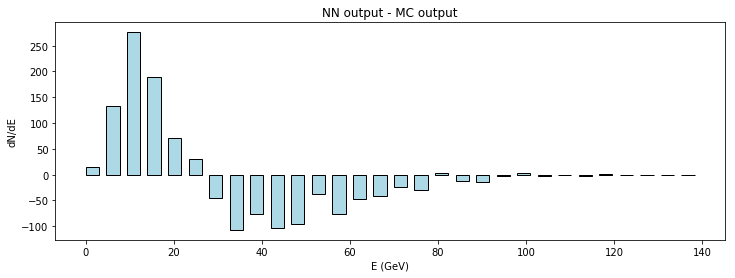

In [24]:
idx = np.arange(0,140, step=140/30)
diff=plt.bar(idx, 
             height=(h_nn[0]-h_reco[0]), edgecolor='black', 
             linewidth=1, color='lightblue',width = 3, align = 'edge') 
plt.xlabel('E (GeV)')
plt.ylabel('dN/dE')
plt.title("NN output - MC output")
fig = plt.gcf()
fig.set_size_inches(12,4)
plt.savefig(PATH+'/difference.eps', format='eps',dpi=100)

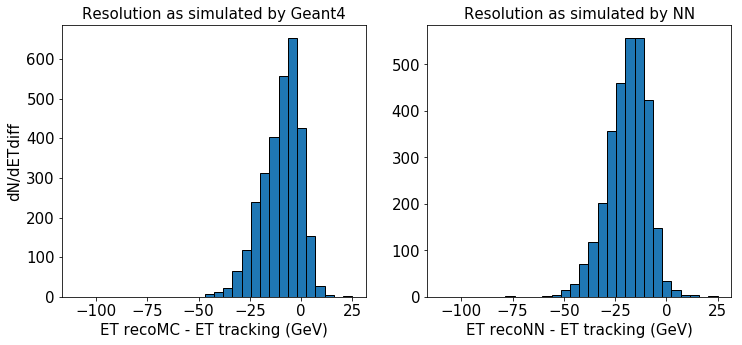

In [25]:
plt.subplot(1,2,1)
plt.tick_params(labelsize=15);


h_reco = plt.hist(diffMC/1000,bins=30, range=(-110,25), edgecolor='black');
plt.xlabel('ET recoMC - ET tracking (GeV)', fontsize=15)
plt.ylabel('dN/dETdiff', fontsize=15)
plt.title('Resolution as simulated by Geant4', fontsize=15)
plt.subplot(1,2,2)
plt.tick_params(labelsize=15);


h_nn = plt.hist(diffNN/1000,bins=30, range=(-110,25), edgecolor='black');
plt.xlabel('ET recoNN - ET tracking (GeV)', fontsize=15)

#plt.ylabel('dN/dETdiff', fontsize=15)
plt.title('Resolution as simulated by NN', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.savefig(PATH+'/resolution.eps', format='eps', dpi=100)




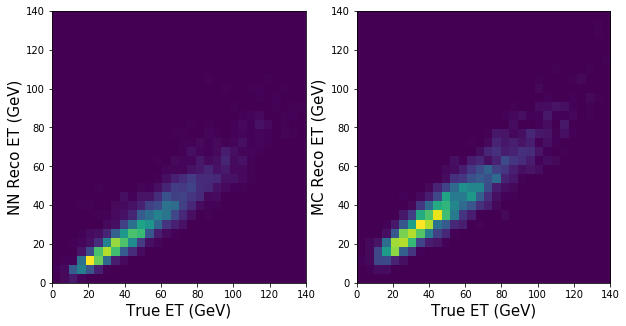

In [26]:
plt.subplot(1,2,1)
plt.hist2d(test_true_hist/1000,test_reco_NN_hist/1000,  range=([[0,140],[0,140]]), bins=30);
plt.xlabel('True ET (GeV)', fontsize=15)
plt.ylabel('NN Reco ET (GeV)', fontsize=15)
fig=plt.gcf()
fig.set_size_inches(5,5)
plt.subplot(1,2,2)
plt.hist2d(test_true_hist/1000,test_reco_MC_hist/1000, range=([[0,140],[0,140]]), bins=30);
plt.xlabel('True ET (GeV)', fontsize=15)
plt.ylabel('MC Reco ET (GeV)', fontsize=15)
fig=plt.gcf()
fig.set_size_inches(10,5)
plt.savefig(PATH+'/scatterplot.eps', format='eps', dpi=100)


In [27]:
test_reco_inner = get_inner_HCAL(test_reco)
test_reco_outer = get_outer_HCAL(test_reco)

In [28]:
test_reco_inner_NN = get_inner_HCAL(test_reco_NN_test)
test_reco_outer_NN = get_outer_HCAL(test_reco_NN_test)

In [29]:
test_reco_inner_NN.sum(axis=0).max(),test_reco_inner.sum(axis=0).max()

(279970.38, 550056.0)

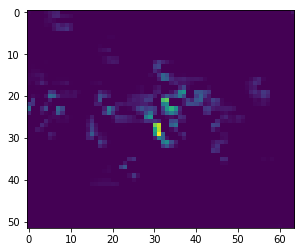

In [30]:
plt.imshow(test_reco_NN[14].reshape(52,64))

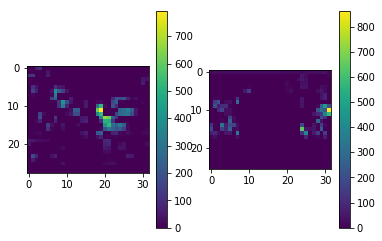

In [31]:
plt.subplot(1,2,1)
plt.imshow(test_reco_inner_NN[4].reshape(28,32))
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(test_reco_outer_NN[4].reshape(26,32))
plt.colorbar()

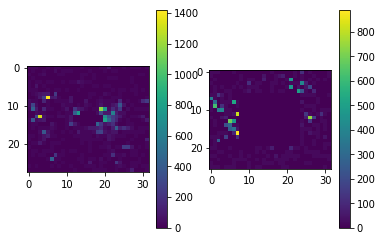

In [32]:
plt.subplot(1,2,1)
plt.imshow(test_reco_inner[4].reshape(28,32))
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(test_reco_outer[4].reshape(26,32))
plt.colorbar()

In [33]:


indices_MC_inner, indices_MC_outer, triggered_true_inner_MC, triggered_true_outer_MC, _, _ = get_triggered_events(test_true, test_reco_inner, test_reco_outer)



In [34]:
len(indices_MC_inner), len(indices_MC_outer)

(531, 188)

In [35]:


indices_NN_inner, indices_NN_outer, triggered_true_inner_NN, triggered_true_outer_NN, _, _ = get_triggered_events(test_true, test_reco_inner_NN, test_reco_outer_NN)



In [36]:
len(indices_NN_inner), len(indices_NN_outer)

(172, 124)

In [37]:
total_MC=np.concatenate((triggered_true_outer_MC,triggered_true_inner_MC))
total_NN=np.concatenate((triggered_true_outer_NN,triggered_true_inner_NN))

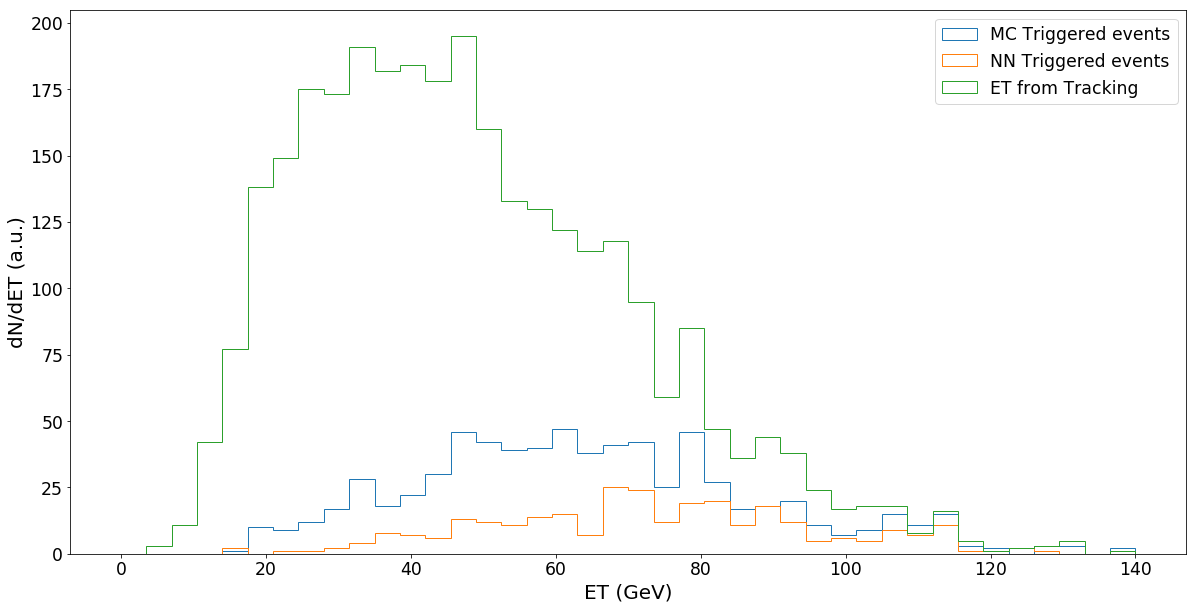

In [38]:

a_MC=plt.hist(total_MC/1000,    range=(0,140), bins=40,  histtype='step',  label='MC Triggered events',)#  range=(0,160))
a_NN=plt.hist(total_NN/1000,    range=(0,140), bins=40,  histtype='step',   label='NN Triggered events',)#  range=(0,160))
b=plt.hist(test_true_hist/1000, range=(0,140), bins=40,histtype='step',  label='ET from Tracking',)# range=(0,160))
plt.tick_params(labelsize='xx-large')
plt.xlabel('ET (GeV)', fontsize=20)
plt.ylabel('dN/dET (a.u.)', fontsize=20)
plt.legend(fontsize='xx-large')
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.savefig(PATH+'/eff_1.png',dpi=100)

In [215]:
#a_MC_np, a_MC_edges = np.histogram(total_MC/1000,bins=40,             )#range=(0,200) )#,  label='MC Triggered events')
#a_NN_np, a_NN_edges = np.histogram(total_NN/1000,bins=40,             )#range=(0,200) )#,   label='NN Triggered events')
#a_true_np, a_true_edges = np.histogram(test_true_hist/1000, bins=40,  )#range=(0,140) )
#
#bincenters = 0.5*(a_NN_edges[1:]+a_NN_edges[:-1])
#
#a_MC_std = np.sqrt(a_MC_np)
#a_NN_std = np.sqrt(a_NN_np)
#a_true_std = np.sqrt(a_true_np)
#
#plt.errorbar(bincenters, a_true_np,yerr=a_NN_std, xerr=0.5 , fmt='o')
#plt.errorbar(bincenters, a_MC_np,  yerr=a_MC_std, xerr=0.5 , fmt='o', label='MC Triggered events')
#plt.errorbar(bincenters, a_NN_np,  yerr=a_NN_std, xerr=0.5 , fmt='o',label='NN Triggered events')
#plt.tick_params(labelsize='xx-large')
#plt.xlabel('ET (GeV)', fontsize=20)
#plt.ylabel('dN/dET (a.u.)', fontsize=20)
#plt.legend(fontsize='xx-large')
#fig = plt.gcf()
#fig.set_size_inches(16,10)
#plt.savefig(PATH+'/eff_1.png',dpi=100)

In [216]:
b[0]

array([  0.,   1.,  19.,  32.,  60., 104., 137., 142., 170., 205., 216.,
       200., 183., 197., 147., 166., 166., 130., 107., 113.,  90.,  72.,
        71.,  47.,  42.,  37.,  32.,  31.,  18.,   7.,  11.,  11.,   6.,
         6.,   3.,   4.,   4.,   6.,   0.,   4.])

In [217]:
eff_MC = np.zeros_like(b[0])
eff_NN = np.zeros_like(b[0])
for i in range(len(b[0])):
    if b[0][i]!=0:
        eff_MC[i]=a_MC[0][i]/b[0][i]
        eff_NN[i]=a_NN[0][i]/b[0][i]

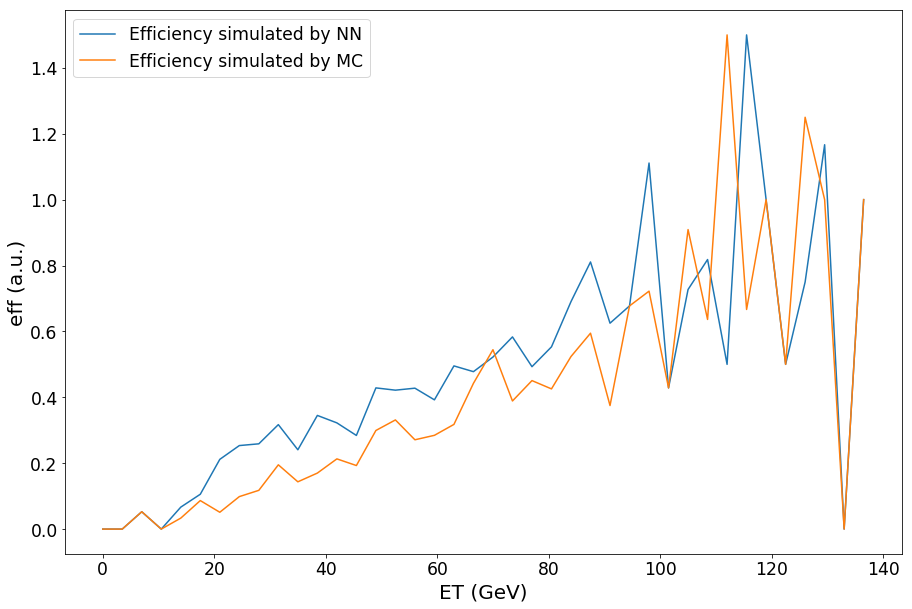

In [304]:
idx = np.arange(0,140, step=140/40)
#plt.subplot(1,2,2)
plt.plot(idx,eff_NN, label='Efficiency simulated by NN')
plt.plot(idx,eff_MC, label='Efficiency simulated by MC')
plt.legend(fontsize='xx-large')
plt.tick_params(labelsize='xx-large')
plt.xlabel('ET (GeV)', fontsize=20)
plt.ylabel('eff (a.u.)', fontsize=20)
#plt.subplot(1,2,1)
#a_MC=plt.hist(triggered_true_inner_MC/1000,bins=40,histtype='step', range=(0, 160),  label='MC Triggered events')
#a_NN=plt.hist(triggered_true_inner_NN/1000,bins=40,histtype='step', range=(0, 160),  label='NN Triggered events')
#b=plt.hist(test_true_hist/1000,bins=40,histtype='step', range=(0, 160),  label='ET from Tracking')
#plt.tick_params(labelsize='xx-large')
#plt.xlabel('ET (GeV)', fontsize=20)
#plt.ylabel('dN/dET (a.u.)', fontsize=20)
#plt.legend(fontsize='xx-large')
fig = plt.gcf()
fig.set_size_inches(15,10)

plt.savefig(PATH+'/eff_2.png',dpi=100)

In [219]:
efficiencies={
    'MC':total_MC,
    'NN':total_NN,
    'true':test_true
}

In [220]:
with open(PATH+'/efficiencies_full.pickle','wb') as f:
    pickle.dump(efficiencies, f, protocol=2)

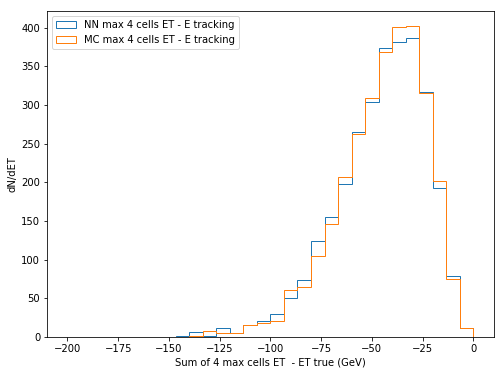

In [221]:
four_cells_diff_NN= np.array([
       four_cells(test_reco_NN_test[i]).sum()- test_true[i].sum()  for i in range(len(test_reco))
])    
four_cells_diff_MC= np.array([
       four_cells(test_reco[i]).sum() - test_true[i].sum() for i in range(len(test_reco))
])
plt.hist(four_cells_diff_NN/1000, bins=30,range=(-200,0),  label = 'NN max 4 cells ET - E tracking',histtype='step')
plt.hist(four_cells_diff_MC/1000, bins=30,range=(-200,0),  label = 'MC max 4 cells ET - E tracking', histtype='step')
plt.legend(loc=2);
plt.xlabel('Sum of 4 max cells ET  - ET true (GeV)')
plt.ylabel('dN/dET')
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.savefig(PATH+'/four_cells_diff_combined.eps', format='eps', dpi=100)

four cells diff mean -746.0126953125, std 1924.9454345703125


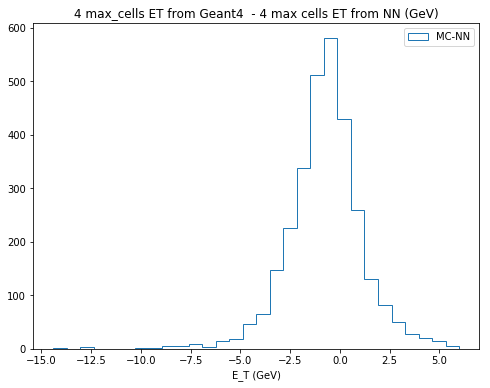

In [222]:
four_cells_diff= four_cells_diff_NN-four_cells_diff_MC
plt.title('4 max_cells ET from Geant4  - 4 max cells ET from NN (GeV)')
plt.hist((four_cells_diff)/1000, bins=30, label = 'MC-NN',  histtype='step');
plt.xlabel('E_T (GeV)')
plt.legend();
print('four cells diff mean {0}, std {1}'.format(four_cells_diff.mean(), four_cells_diff.std()))
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.savefig(PATH+'/four_cells_diff.eps', format='eps', dpi=100)

In [223]:
i=2

In [224]:
X_A=test_true[i]
X_B=test_reco[i]
sample_nn=test_reco_NN[i]
n_H_A=n_H_B=52
n_W_A=n_W_B=64

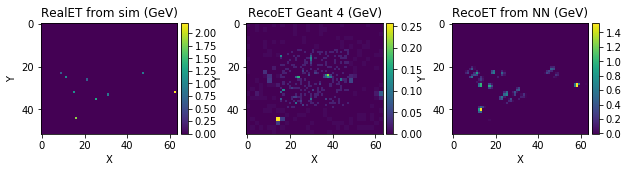

In [225]:
plt.subplot(1,3,1)
plt.gca().set_title('RealET from sim (GeV)')
plt.xlabel('X')
plt.ylabel('Y')
ax = plt.gca()
im = ax.imshow(X_A.reshape(n_H_A,n_W_A)/1000)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=0.4,hspace=0.2)

plt.subplot(1,3,2)
plt.gca().set_title('RecoET Geant 4 (GeV)')
#plt.imshow(X_B.reshape(n_H_B,n_W_B))
plt.xlabel('X')
plt.ylabel('Y')
ax = plt.gca()
im = ax.imshow(X_B.reshape(n_H_B,n_W_B)/1000)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=0.4,hspace=0.2)

plt.subplot(1,3,3)
plt.gca().set_title('RecoET from NN (GeV)')
#plt.imshow(sample_nn.reshape(n_H_B,n_W_B)/10)
plt.xlabel('X')
plt.ylabel('Y')
ax = plt.gca()
im = ax.imshow(sample_nn.reshape(n_H_B,n_W_B)/1000)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=0.4,hspace=0.2)

fig = plt.gcf()
fig.set_size_inches(10,8)
plt.savefig(PATH+'/single_event_{0}.png'.format(i))

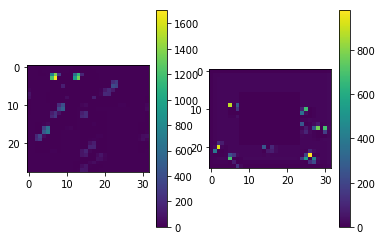

In [226]:
plt.subplot(1,2,1)
plt.imshow(test_reco_inner_NN[0].reshape(28,32))
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(test_reco_outer_NN[0].reshape(26,32))
plt.colorbar()

In [227]:
with open('/disk/lhcb_data/davide/HCAL_project_full_event/csv/MCtracker_info.pickle', 'rb') as f:
    tracks=pickle.load(f)
    
pos_rejected={}
i=0
while os.path.exists('/disk/lhcb_data/davide/HCAL_project_full_event/reco/rejected'+str(i)+'.pickle'):
#while i < 5:
    file_path = '/disk/lhcb_data/davide/HCAL_project_full_event/reco/rejected'+str(i)+'.pickle'
    with open(file_path, 'rb') as handle:
        pos_rejected[i]=pickle.load(handle)
    i+=1

In [228]:
width_X=8404.0
width_Y=6828.0
#number of events
batch_size=3000
n_batches=len(tracks['xProjections'])

X_pixels=64
Y_pixels=52

In [229]:
for j in range(n_batches):
    for i in range(batch_size):
        tracks["xProjections"][j][i][0]/=(width_X/2)
        tracks["yProjections"][j][i][0]/=(width_Y/2)
        
        tracks["xProjections"][j][i][0]*=32
        tracks["yProjections"][j][i][0]*=26
       
        tracks["xProjections"][j][i][0]+=32
        tracks["yProjections"][j][i][0]+=26

In [236]:
inner={}
outer={}


for n in range(start_batch,n_batches):
    
    inner[n]={}
    outer[n]={}
    
    inner[n]['TOS']=np.empty(shape=(batch_size,),dtype='bool')
    inner[n]['TIS']=np.empty(shape=(batch_size,),dtype='bool')
    inner[n]['ET']=np.empty(shape=(batch_size,))
    
    outer[n]['TOS']=np.empty(shape=(batch_size,),dtype='bool')
    outer[n]['TIS']=np.empty(shape=(batch_size,),dtype='bool')
    outer[n]['ET']=np.empty(shape=(batch_size,))
    
    for event in range(batch_size):
            
            if event not in pos_rejected[n]:
                
                value_inner, pos_inner = get_4_max_cells(test_reco_inner[event])
                value_outer, pos_outer = get_4_max_cells(test_reco_outer[event])
                
                inner[n]['ET'][event]=value_inner.sum()
                outer[n]['ET'][event]=value_outer.sum()
                
                if value_inner.sum()>3680:
                    
                    for ntrack in range(3):
                    
                        y=int(np.floor(tracks['yProjections'][n][event][0][ntrack]))
                        x=int(np.floor(tracks['xProjections'][n][event][0][ntrack]))
                        

                        if pos[0]==y or pos[0]==y+1 or pos[1]==x or pos[1]==x+1:
                            inner[n]['TOS'][event]=True
                            
                        else:
                            inner[n]['TIS'][event]=True
                            
                        
                if value_outer.sum()>3680:
                    
                    for ntrack in range(3):
                    
                        y=int(np.floor(tracks['yProjections'][n][event][0][ntrack]))
                        x=int(np.floor(tracks['xProjections'][n][event][0][ntrack]))
                        

                        if pos[0]==y or pos[0]==y+1 or pos[1]==x or pos[1]==x+1:
                            outer[n]['TOS'][event]=True
                        else:
                            outer[n]['TIS'][event]=True
                            
                    
                        

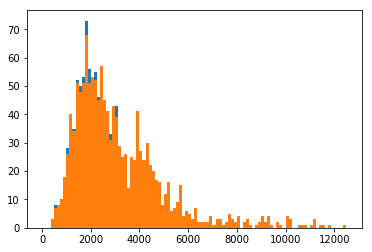

In [307]:
TOS_evts = plt.hist(inner[2]['ET'][inner[2]['TOS']],range=(0.001,1.25e4),bins=100)
TIS_evts = plt.hist(inner[2]['ET'][inner[2]['TIS']],range=(0.001,1.25e4),bins=100)

In [325]:
(inner[2]['TIS'].mean()+outer[2]['TIS'].mean())/2

0.5181666666666667

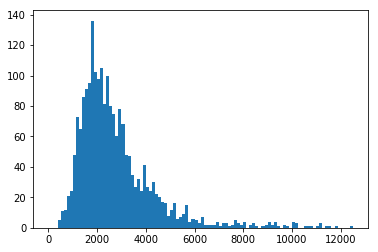

In [308]:
tot_evts=plt.hist(inner[2]['ET'],range=(0.001,1.25e4),bins=100);

In [314]:
#eff_MC = np.zeros_like(b[0])
TIS_eff_NN = np.zeros_like(tot_evts[0])
TOS_eff_NN = np.zeros_like(tot_evts[0])
for i in range(len(tot_evts[0])):
    if tot_evts[0][i]!=0:
        TIS_eff_NN[i]=TIS_evts[0][i]/tot_evts[0][i]
        TOS_eff_NN[i]=TOS_evts[0][i]/tot_evts[0][i]

In [315]:
idx2 = np.arange(0.001,1.25e4, step=1.25e4/100)

In [316]:
idx2.shape

(100,)

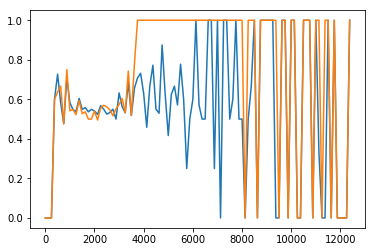

In [318]:
plt.plot(idx2,TOS_eff_NN)
plt.plot(idx2,TIS_eff_NN)

In [320]:
tracks['L0HadronDec_TIS']

{0: array([False, False, False, ..., False, False, False]),
 1: array([False,  True, False, ..., False, False,  True]),
 2: array([False, False, False, ..., False, False, False]),
 3: array([ True, False,  True, ..., False, False, False]),
 4: array([False, False, False, ..., False,  True, False])}